This is the first notebook for quantification of FISH expression. In here we quantify intensity in 
various forms (histograms of spot intensities, spot sizes and summed spot intensities).
We also quantify the SNR, the signal to noise ratio and the background.


23/04/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./HOX_pipeline.png" alt="LNP pipeline" width="1200" height="477">

In [3]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [5]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.plots import Plots
from utils.file_handling import FileProcessor
from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis

tk  = Track()
sg  = Segmentation()
pt  = Plots()
st  = Synthesis()
fp  = FileProcessor()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('2024-11-18_Helena-Ho…

In [7]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']

In [8]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('EXPERIMENT', 'CONTRO…

In [9]:
n2  = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

EXPERIMENT


In [10]:
channels_cell = constants['CHANNELS'] # DAPI doesn't make sense
dropdown3 = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'));
display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [47]:
n3     = np.where(np.array(channels_cell) == dropdown3.value)[0][0]
chan_c = channels_cell[n3]; print(chan_c)

col_channels = constants['COLORS']  # associated color to this channel
color        = col_channels[n3]; print(color)

HOXA10
red


In [13]:
detection_methods = ['UFISH','BIGFISH']
dropdown4         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown4)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [14]:
n4     = np.where(np.array(detection_methods) == dropdown4.value)[0][0]
method = detection_methods[n4]; print(method)

UFISH


In [15]:
folder_path_figures = Path(f"../Analysis/{batch_name}/Figures") # create folder for figures (all figures will be stored there)
if not folder_path_figures.exists():
    folder_path_figures.mkdir(parents=True)

#### Spot intensity: extract intensity, spot size, summed spot intensity over estimated size.

In [48]:
batch_fish         = constants[f'BATCH_{modality}_{chan_c}']

dots_path          = constants[f'DOTS_{method}_{modality}_{chan_c}_PATH']
dict_dots          = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

window_size        = 17#13, 7      # This parameter is critical
n_int_points       = 11
median_filt_size   = 4
frac               = .15#0.25   # This parameter is critical. 
#   Anyhow validate visually afterwards with the napari window. Iterate until the dot size estimation makes sense visually.

voxel_size_yx      = constants[f'VOXEL_SIZE_NM_BF_{modality}_{chan_c}_YX']
obj_rad_yx         = constants[f'OBJECT_RADIUS_NM_BF{modality}_{chan_c}_YX']

voxel_size_nm      = (voxel_size_yx, voxel_size_yx)  # important parameter: might be seen opening the image information in fiji or loooking at the microscope metadata.
object_radius_nm   = (obj_rad_yx, obj_rad_yx)

Batch processing

In [49]:
for ind_l, file in enumerate(batch_fish):
    im_rna                   = io.imread(Path(file))   
    file_name                = Path(file).stem     
    filebase_name            = '_'.join(file_name.split('_')[:-1])

    df_spots_filt            = dict_dots[filebase_name]
    df_w_intensity           = sg.extract_intensities_df(df_spots_filt, im_rna)  
    df_w_frac_signal         = sg.determine_spots_width_frac_signal_df(im_rna, df_w_intensity, h_window=window_size, size_median_filt=median_filt_size, frac=frac)
    df_w_sum_intensity       = sg.compute_sum_spot_intensity_df(df_w_frac_signal, im_rna)
    df_w_snr_back            = st.compute_snr_df(im_rna, df_w_sum_intensity, voxel_size_nm, object_radius_nm)        
    dict_dots[filebase_name] = df_w_snr_back
                    
fp.save_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'], dict_dots, im_rna.ndim)

#### Manual step      (WARNING: Manual input required)
Organize your batch in rows and columns: rows can be conditions, and columns time or rows can be repetitions and columns conditions
store as (line, column) for each element of the batch. Put None in case you don't want to display it. 
For instance if your batch files is ['file_control0', 'file_control1', 'file_control2', 'file_rep1_c1', 'file_rep2_c1', 'file_rep1_c2', 'file_rep2_c2'] and you want to organize your 
display as:

|          | Concentration 1 | Concentration 2 |
|----------|----------|----------|
| **Rep 1**| R1, C1   | R1, C2   | 
| **Rep 2**| R2, C1   | R2, C2   |


Then, insert the coordinates, in the following way,  do for a batch of experiments like:

batch      = [`Exp to discard`, `Exp to discard`, `Exp to discard`, `R1,C1`, `R2,C1`,`R1,C2`,  `R2,C2` ]

batch_plot = [`None` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None `&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,`(0,0) `,`(1,0) `,`(0,1) `,`(1,1)`]

In [50]:
leg_x = ['6h', '24h', '48h']
leg_y = ['NT', 'GDF', 'FGF-GDF']
name  = f'{modality}_{chan_c}_{method}'

lines = len(leg_y)
cols  = len(leg_x)

print([Path(el).stem for el in batch_fish])
batch_plot         = [(0,0), (0,1), (0,2), (1,0), (1, 1), (1,2), (2,0), (2,1), (2,2)]             # batch_pot has the same dimension as batch.
batch_subselection = [1 if el is not None else 0 for el in batch_plot]          # given the choice made before, we will only plot those files.

['HM40-J3DIFF-NT6h-HOXA10-620_HOXC8-520-1002-1_HOXA10', 'HM40-J3DIFF-NT24h-HOXA10-620_HOXC8-520-1005-1_HOXA10', 'HM40-J3DIFF-NT48h-HOXA10-620_HOXC8-520-1008-1_HOXA10', 'HM40-J3DIFF-GDF6h-HOXA10-620_HOXC8-522-1_HOXA10', 'HM40-J3DIFF-GDF24h-HOXA10-620_HOXC8-525-1_HOXA10', 'HM40-J3DIFF-GDF48h-HOXA10-620_HOXC8-528-1_HOXA10', 'HM40-J3DIFF-FGFGDF6h-HOXA10-620_HOXC8-531-1_HOXA10', 'HM40-J3DIFF-FGFGDF24h-HOXA10-620_HOXC8-534-1_HOXA10', 'HM40-J3DIFF-FGFGDF48h-HOXA10-620_HOXC8-537-1_HOXA10']


# Intensity characterization

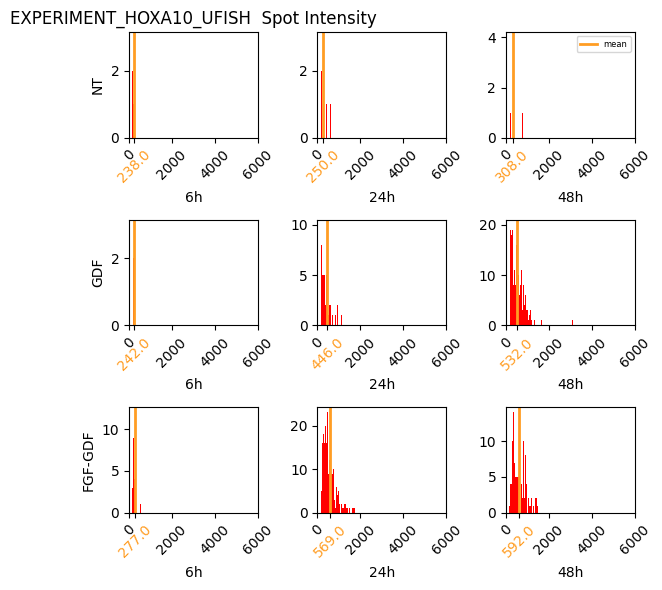

In [51]:
dict_dots         = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

fig, axes = plt.subplots(lines, cols, figsize=(6, 6))
for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        filebase_name = '_'.join(Path(file).stem.split('_')[:-1])
        ind_l, ind_c  = batch_plot[ind]
        ints          = dict_dots[filebase_name]['intensity'].to_numpy()
        ints          = ints[~np.isnan(ints)]
 
        pt.plot_intensities(ints, fig, axes, ind_l, ind_c,
                                    leg_x[ind_c], leg_y[ind_l], name + '  Spot Intensity', color=color, color_mean= '#FF9D23', bins= 100, max_x = 4500) # modify the parameter max_x

fig.tight_layout()
fig.savefig(Path(folder_path_figures)/f'{batch_name}_spots_intensity_{name}.png', bbox_inches="tight")   

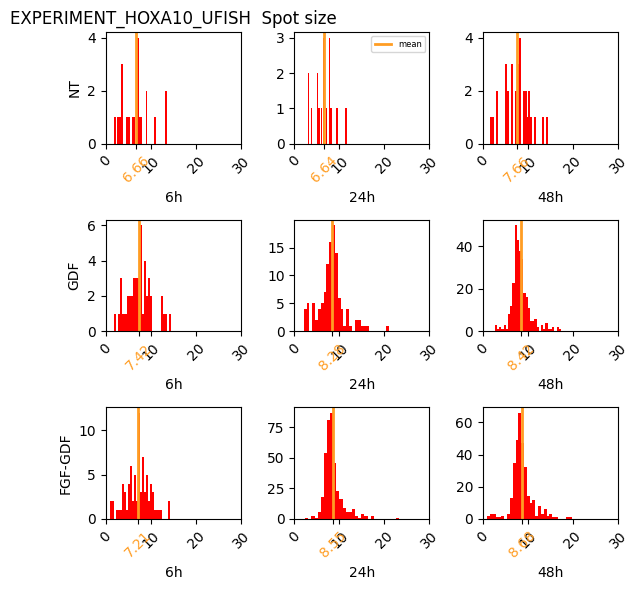

In [52]:
dict_dots         = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

fig, axes = plt.subplots(lines, cols, figsize=(6, 6))
for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        filebase_name = '_'.join(Path(file).stem.split('_')[:-1])
        ind_l, ind_c  = batch_plot[ind]
        
        widths = dict_dots[filebase_name]['spot_width'].to_numpy()
        widths = widths[~np.isnan(widths)]
        
        pt.plot_intensities(widths, fig, axes, ind_l, ind_c,
                            leg_x[ind_c], leg_y[ind_l], name + '  Spot size', color=color, shape =(2,2), color_mean= '#FF9D23', bins= 30, max_x = 25, num_decimals=2)

fig.tight_layout()
fig.savefig(Path(folder_path_figures)/f'{batch_name}_spot_size_{name}.png', bbox_inches="tight")

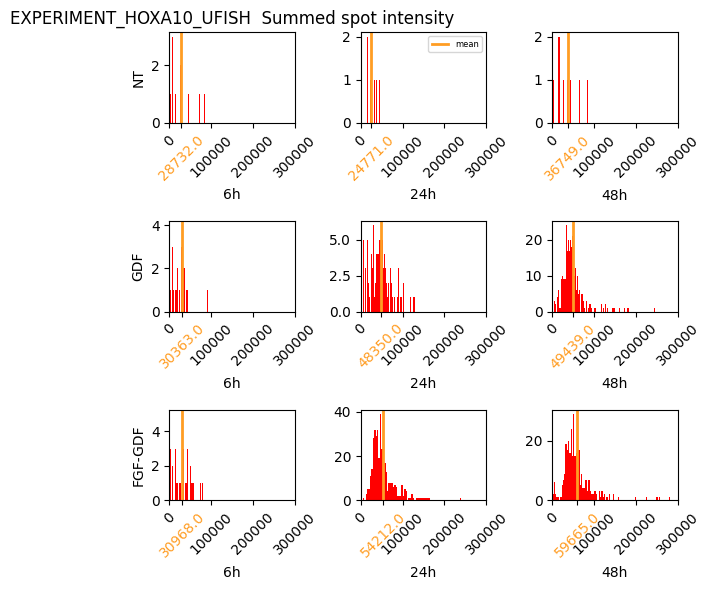

In [58]:
dict_dots = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

fig, axes = plt.subplots(lines, cols, figsize=(6, 6))
for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        ind_l, ind_c  = batch_plot[ind]
        filebase_name = '_'.join(Path(file).stem.split('_')[:-1])

        sum_i = dict_dots[filebase_name]['sum_intensity'].to_numpy()
        sum_i = sum_i[~np.isnan(sum_i)]

        pt.plot_intensities(sum_i, fig, axes, ind_l, ind_c,
                            leg_x[ind_c], leg_y[ind_l], name + '  Summed spot intensity', color=color, shape =(2,2), color_mean= '#FF9D23', bins= 100, max_x = 500*500)

fig.tight_layout()
fig.savefig(Path(folder_path_figures)/  f'{batch_name}_mean_spot_intensities_{name}.png', bbox_inches="tight")

In [59]:
# Visual QC

dict_dots    = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

viewer_spots = napari.Viewer(title=f"Spot viewer {batch_name}")
counter      = 0
for ind_l, file in enumerate(batch_fish):
    if batch_subselection[ind_l]:
        file_name     = '_'.join(Path(file).stem.split('_')[:-1])
        ind_l, ind_c  = batch_plot[ind_l]
    
        im_rna    = io.imread(file)
        if im_rna.ndim == 3:      
            im_rna_2d = np.max(im_rna, axis=0)
        elif im_rna.ndim == 2:
            im_rna_2d = im_rna

        val_max   = np.percentile(im_rna_2d, 99)
        viewer_spots.add_image(im_rna_2d, contrast_limits=[0, val_max], rgb=False, name=f"{file_name}")
       
        df_spots  = dict_dots[file_name]
                
        filtered_df = df_spots[(df_spots['in_mask'] == True) & (df_spots['spot_width'].notna())]
        if 'Z' in filtered_df.columns:
            coords = filtered_df[['Z', 'Y', 'X']].to_numpy()[:,1:]
        else:
            coords = filtered_df[['Y', 'X']].to_numpy()
                
        temp_size = filtered_df['spot_width'].to_numpy()  
          
            
        viewer_spots.add_points(coords, name=f"Spots {file_name}", size=temp_size.flatten(), border_color=color, face_color=[0, 0, 0, 0]);
        
        if counter !=0:
            viewer_spots.layers[f"{file_name}"].visible       = False
            viewer_spots.layers[f"Spots {file_name}"].visible = False    
        counter = counter + 1

# snr  over experiments

In [60]:
short_names = [f'NT 6h {chan_c}', f'NT 24h {chan_c}', f'NT 48h {chan_c}', f'GDF 6h {chan_c}', f'GDF 24h {chan_c}', f'GDF 48h {chan_c}',  f'FDF-GDF 6h {chan_c}', f'FDF-GDF 24h {chan_c}', f'FDF-GDF 48h {chan_c}' ]  # I define manually more concise names for the experiments        

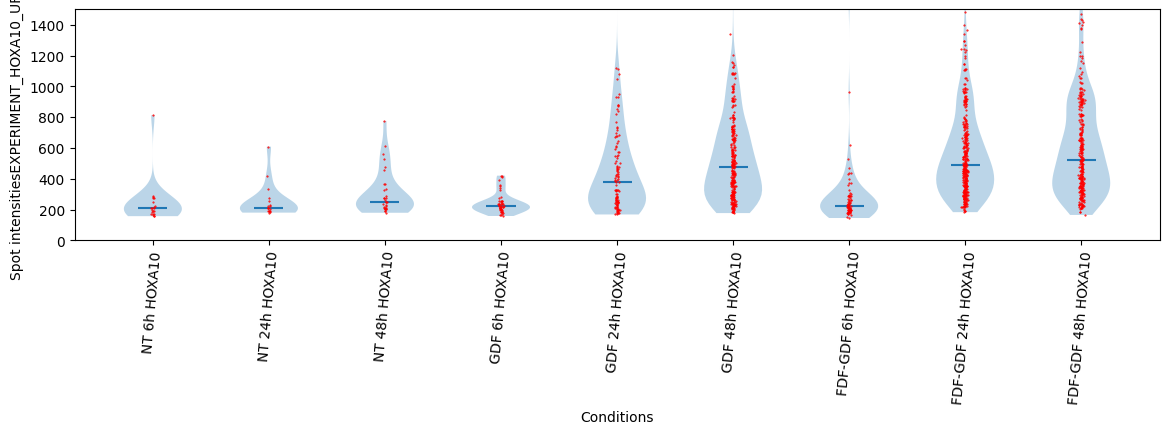

In [63]:
dict_dots   = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

ints, names = [], [] # format for plotting
for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_name  = '_'.join(Path(file).stem.split('_')[:-1])
        df_spots   = dict_dots[file_name] 
        intensities= df_spots[(df_spots['in_mask'] == True) & (df_spots['intensity'].notna())]['intensity'].to_numpy()
        ints.append(intensities)
        names.append(file_name)
 
f_vp = pt.violin_plot_intensities(ints, figsize=(14,3), exp_name= 'Spot intensities' + f'{modality}_{chan_c}_{method}', rotation=85, names_short=short_names, color=color, ymax = 1500) #12500
f_vp.savefig(Path(folder_path_figures)/f'{batch_name}_dots_int_{name}.png', bbox_inches="tight")

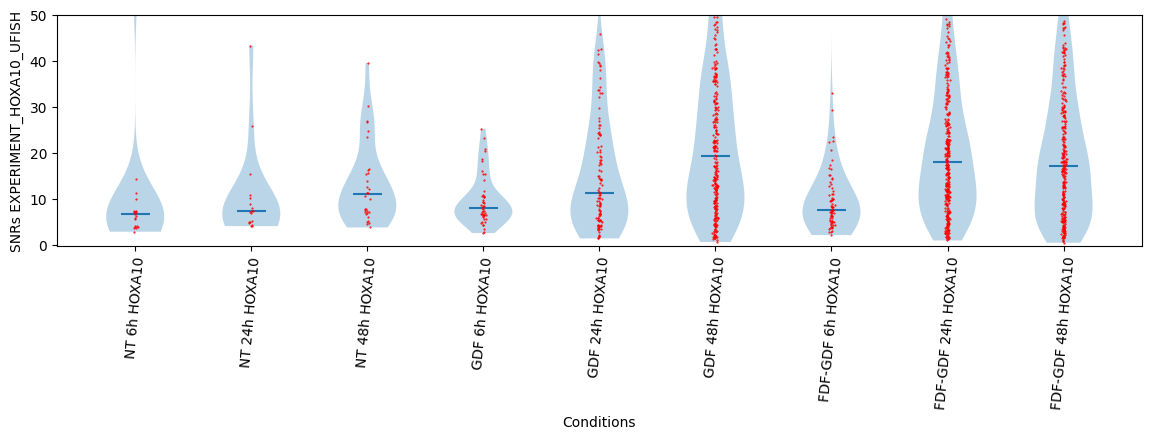

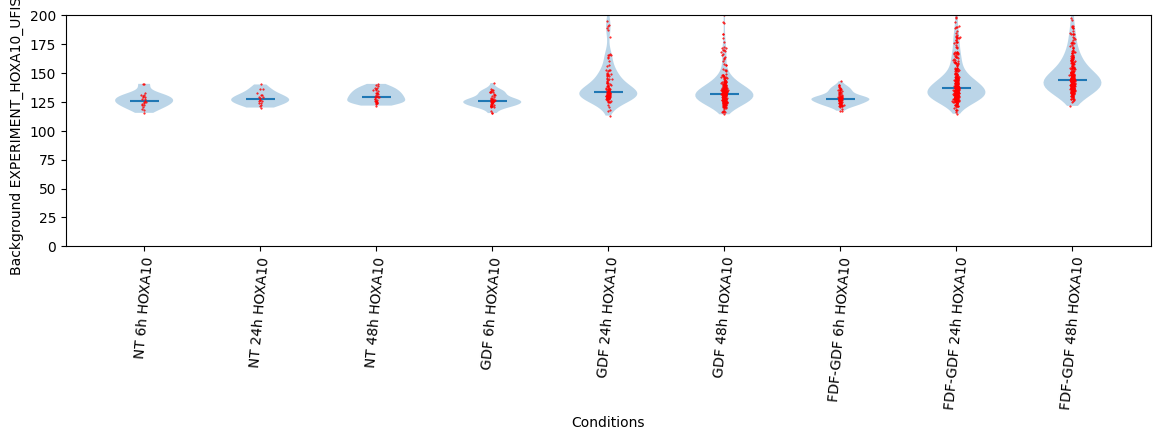

In [67]:
dict_dots      = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

snr_s          = []
std_snr        = []
bckgrd         = []
bckgrd_std     = [] 
names          = []
    
snrs, bcks, names = [], [], [] # format for plotting
     
for ind, file in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_name  = '_'.join(Path(file).stem.split('_')[:-1])
        df_spots   = dict_dots[file_name] 
        snr        = df_spots[(df_spots['in_mask'] == True) & (df_spots['snr'].notna())]['snr'].to_numpy()
        snrs.append(snr)
        bck        = df_spots[(df_spots['in_mask'] == True) & (df_spots['background'].notna())]['background'].to_numpy()
        bcks.append(bck)
        names.append(file_name)
 
f_snr = pt.violin_plot_intensities(snrs, figsize=(14,3), exp_name='SNRs ' + f'{modality}_{chan_c}_{method}', rotation=85, names_short=short_names, color=color, ymin= -0.3,ymax = 50)
f_snr.savefig(Path(folder_path_figures)/f'{batch_name}_snr_{name}.png', bbox_inches="tight")

f_bck = pt.violin_plot_intensities(bcks, figsize=(14,3), exp_name='Background ' + f'{modality}_{chan_c}_{method}', rotation=85, names_short=short_names, color=color, ymax = 200)
f_bck.savefig(Path(folder_path_figures)/f'{batch_name}_background_{name}.png', bbox_inches="tight")

#### Save constants

In [68]:

WINDOW_SIZE        = window_size
N_INT_POINTS       = n_int_points
FRAC               = frac
MEDIAN_FILT_SIZE   = median_filt_size

In [69]:
constants2 = tk.collect_constants()
tk.save_constants_and_commit_hash(constants2, batch_name, folder_path = Path(f"../Analysis/{batch_name}"))